# Setting

In [1]:
from pf_utils import PortfolioManager as PM 
from pf_utils import FinancialRatios, METRICS, FundDownloader
from pf_widgets import WidgetUniverse, WidgetTransaction, w_date

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

In [3]:
file_cost='transaction_cost'
kw_cost = {'cost': file_cost}

# Data

In [4]:
universe = 'UV_FUND'
fund = PM.create_universe(universe)
cost = PM.get_cost(universe, file=file_cost, path=path_tran)
fee = cost['fee']

64 securities from 2008-11-28 to 2024-11-29 uploaded.
REMINDER: 64 equities converted to daily (days in year: 365)
Daily metrics in Performance statistics must be meaningless
Price data loaded
Cost data transaction_cost_241217.csv loaded


In [5]:
tickers = {k:v for k,v in fund.security_names.items() if 'TDF2045' in v}
tickers = list(tickers.keys())

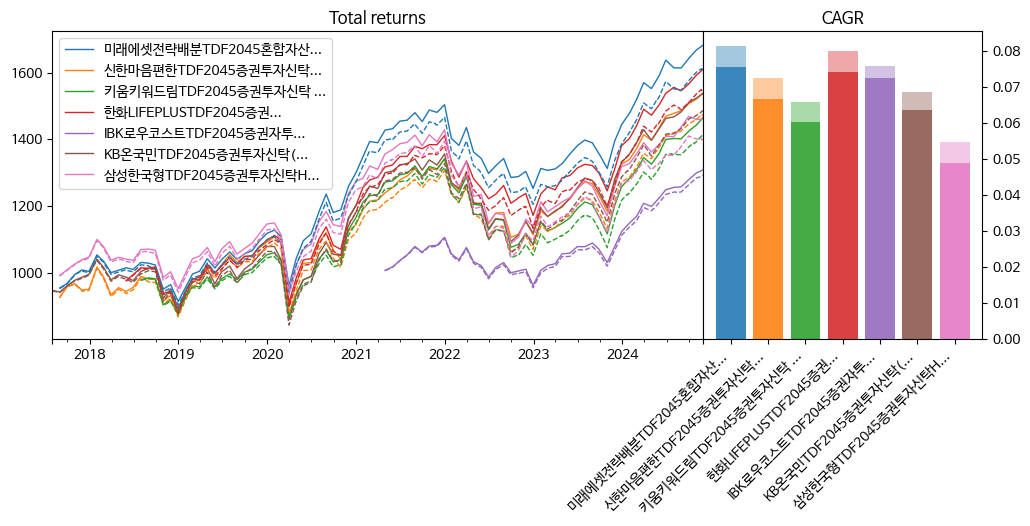

In [6]:
#m = 'total_return'
m = 'cagr'
fund.plot(tickers, fee=fee, base=-1, metric=m)

In [19]:
df = fund.df_prices[tickers]
df= df.loc[df.notna().any(axis=1)]

<Axes: xlabel='date'>

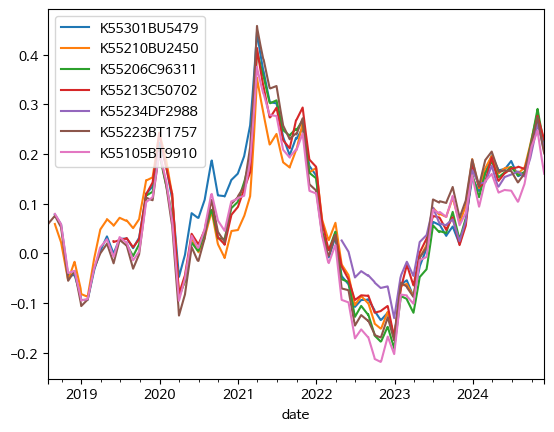

In [20]:
w = 365
df.rolling(w).apply(lambda x: x.iloc[-1] / x.iloc[0] - 1).apply(lambda x: x.dropna()).plot()

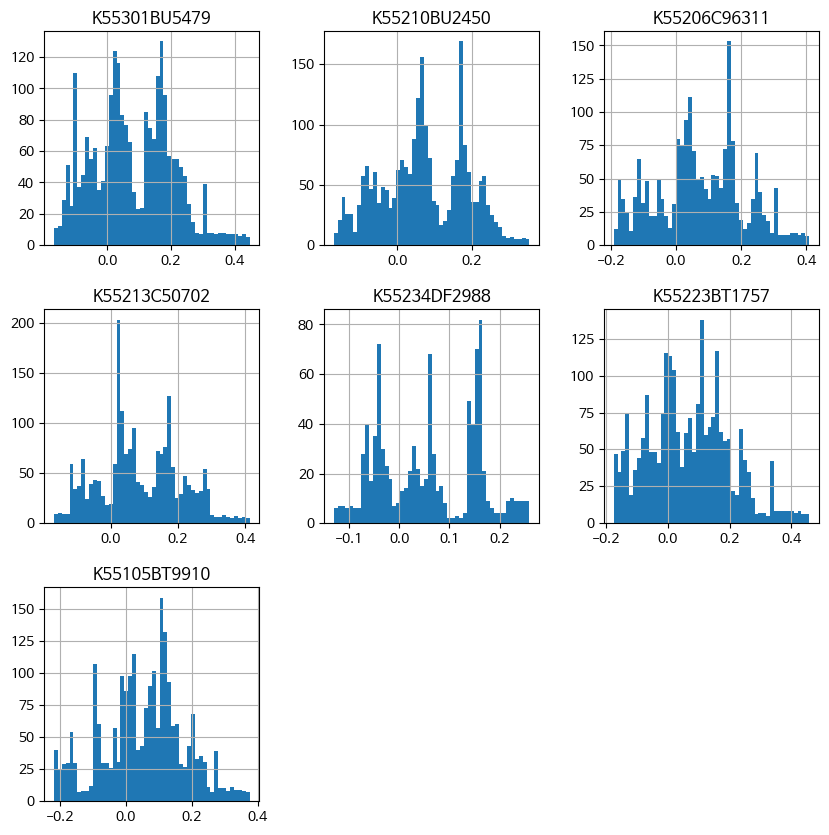

In [21]:
_ = df.rolling(w).apply(lambda x: x.iloc[-1] / x.iloc[0] - 1).apply(lambda x: x.dropna()).hist(bins=50, figsize=(10,10))

In [28]:
#df.rolling(w).apply(lambda x: x.iloc[-1]).dropna()
df.rolling(w).apply(lambda x: x.iloc[-1] / x.iloc[0] - 1).apply(lambda x: x.dropna()).agg(['mean', 'std'])

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
mean,0.080419,0.070898,0.076937,0.086856,0.059451,0.068864,0.053951
std,0.125761,0.113316,0.134982,0.120978,0.097699,0.133971,0.125645


In [36]:
from pf_utils import performance_stats, METRICS

In [37]:
performance_stats(df, metrics=METRICS)

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
start,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30,2021-04-30
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.178707,0.242023,0.152964,0.222988,0.3,0.183772,0.077007
cagr,0.046946,0.062344,0.040515,0.057775,0.075954,0.048199,0.020916
calmar,0.281089,0.354791,0.204636,0.340782,0.581994,0.248329,0.087668
max_drawdown,-0.167016,-0.17572,-0.197987,-0.169537,-0.130506,-0.194095,-0.238581
avg_drawdown,-0.043088,-0.052399,-0.059419,-0.04835,-0.051307,-0.080494,-0.070569
avg_drawdown_days,201.2,225.25,249.5,227.5,272.0,309.666667,282.75
daily_vol,0.014031,0.015662,0.016776,0.013997,0.012462,0.016591,0.017853
daily_sharpe,2.263009,2.672159,1.641891,2.775797,4.059676,1.965997,0.808911


# Bayesian

In [6]:
from pf_utils import BayesianEstimator

In [7]:
df_prices = fund.df_prices[tickers]

In [8]:
be = BayesianEstimator(df_prices, 365)

In [9]:
be.get_stats(align_period=False)

,K55301BU5479,K55210BU2450,K55206C96311,K55213C50702,K55234DF2988,K55223BT1757,K55105BT9910
start,2017-08-31,2017-08-31,2018-07-31,2018-05-31,2021-04-30,2017-07-31,2017-08-31
end,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29,2024-11-29
total_return,0.7637,0.6622,0.4977,0.6503,0.3,0.6252,0.4727
cagr,0.081442,0.072633,0.065864,0.080122,0.075954,0.068478,0.054866
calmar,0.487632,0.388559,0.332667,0.441468,0.581994,0.336192,0.22997
max_drawdown,-0.167016,-0.18693,-0.197987,-0.181491,-0.130506,-0.203686,-0.238581
avg_drawdown,-0.051706,-0.066858,-0.066807,-0.061409,-0.051307,-0.079215,-0.079265
avg_drawdown_days,174.545455,185.9,181.444444,155.4,272.0,245.125,259.25
daily_vol,0.017211,0.019965,0.01976,0.019764,0.012462,0.020666,0.019501
daily_sharpe,3.147562,2.433325,2.237219,2.700721,4.059676,2.221783,1.899708


In [10]:
be.bayesian_sample(freq='yearly', normality_sharpe=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mean, std]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [13]:
var_names = ['_mean', '_vol']
be.bayesian_summary(var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
yearly_mean[K55301BU5479],0.080,0.003,0.076,0.085,0.0,0.0,8190.0,2996.0,1.0
yearly_mean[K55210BU2450],0.071,0.002,0.067,0.076,0.0,0.0,10284.0,3014.0,1.0
yearly_mean[K55206C96311],0.077,0.003,0.071,0.083,0.0,0.0,9955.0,3141.0,1.0
yearly_mean[K55213C50702],0.087,0.003,0.082,0.092,0.0,0.0,8131.0,3023.0,1.0
yearly_mean[K55234DF2988],0.060,0.003,0.054,0.066,0.0,0.0,10315.0,3218.0,1.0
yearly_mean[K55223BT1757],0.069,0.003,0.064,0.074,0.0,0.0,12615.0,3057.0,1.0
yearly_mean[K55105BT9910],0.054,0.003,0.049,0.059,0.0,0.0,11058.0,3083.0,1.0
yearly_vol[K55301BU5479],0.126,0.002,0.122,0.129,0.0,0.0,11552.0,2778.0,1.0
yearly_vol[K55210BU2450],0.113,0.002,0.110,0.116,0.0,0.0,8786.0,2917.0,1.0
yearly_vol[K55206C96311],0.135,0.002,0.131,0.139,0.0,0.0,9408.0,2847.0,1.0


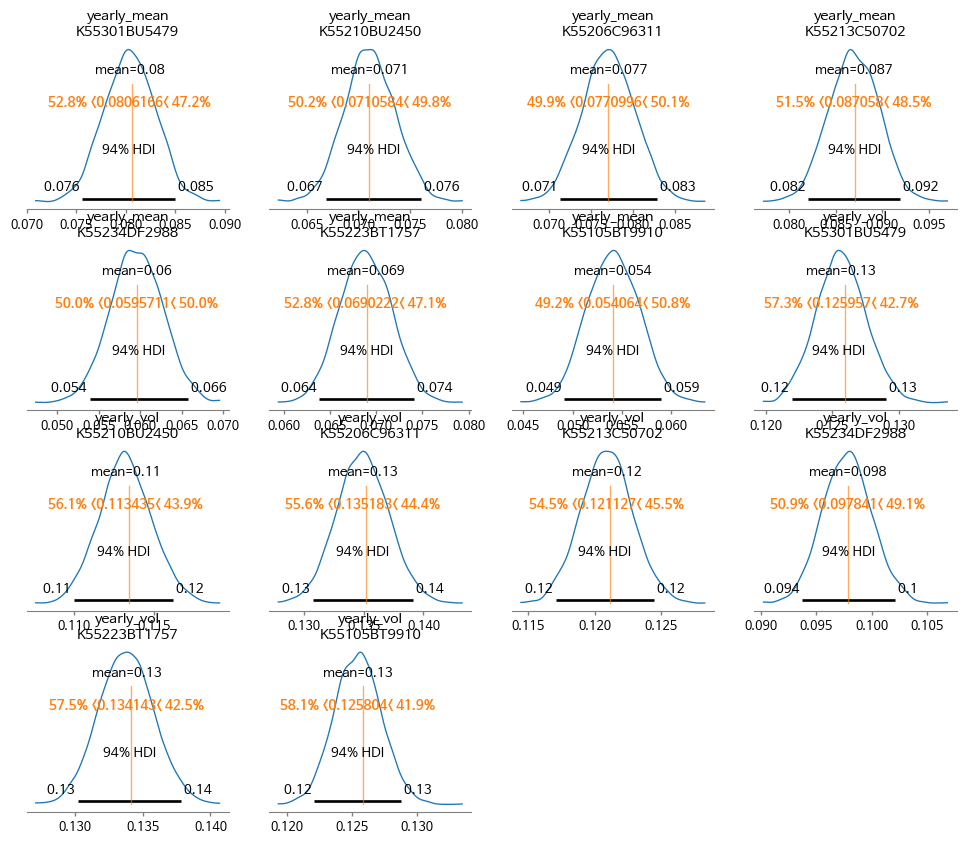

In [14]:
be.bayesian_plot(var_names, figsize=(12,10), textsize=9)

# testing

In [33]:
self = be
freq = 'yearly'
align_period = False
sample_draws=1000
sample_tune=1000
target_accept=0.9
multiplier_std=1000
rate_nu = 29
normality_sharpe=True

periods, freq = self.get_freq_days(freq)
df_prices = self.df_prices
tickers = list(df_prices.columns)

if align_period:
    df_prices = self.align_period(df_prices, axis=0, fill_na=True)
    df_ret = df_prices.pct_change(periods).dropna()
    mean_prior = df_ret.mean()
    std_prior = df_ret.std()
    std_low = std_prior / multiplier_std
    std_high = std_prior * multiplier_std
else:
    ret_list = [df_prices[x].pct_change(periods).dropna() for x in tickers]
    mean_prior = [x.mean() for x in ret_list]
    std_prior = [x.std() for x in ret_list]
    std_low = [x / multiplier_std for x in std_prior]
    std_high = [x * multiplier_std for x in std_prior]
    returns = dict()

In [34]:
std_low

[0.00012595733968587513,
 0.00011343515471378028,
 0.00013518279980760496,
 0.00012112679024075862,
 9.784103969534989e-05,
 0.00013414263815029963,
 0.00012580430362237128]

In [35]:
std_high

[125.95733968587514,
 113.43515471378028,
 135.18279980760494,
 121.12679024075862,
 97.84103969534988,
 134.14263815029963,
 125.80430362237126]

In [36]:
std_prior

[0.12595733968587514,
 0.11343515471378028,
 0.13518279980760495,
 0.12112679024075862,
 0.09784103969534988,
 0.13414263815029964,
 0.12580430362237127]

In [29]:
from pf_utils import performance_stats
df = df_prices.loc[df_prices.notna().any(axis=1)]
#performance_stats(df, align_period=False)

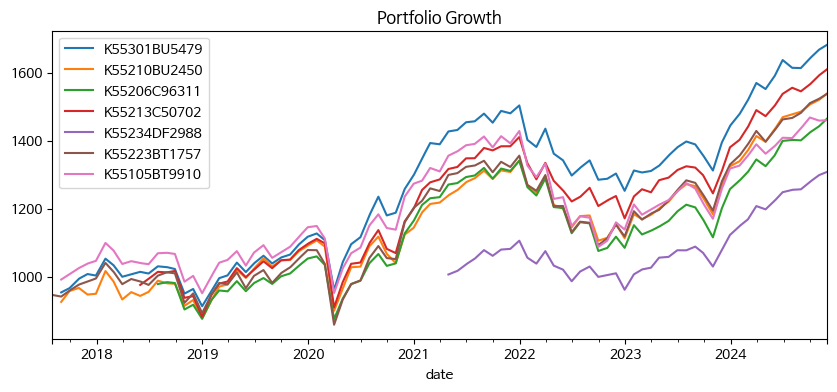

In [30]:
be.plot_historical()

In [48]:
be._calc_mean_return(df_prices, 365, 365)

K55301BU5479    0.080617
K55210BU2450    0.071058
K55206C96311    0.077100
K55213C50702    0.087058
K55234DF2988    0.059571
K55223BT1757    0.069022
K55105BT9910    0.054064
dtype: float64

In [50]:
periods = 31
days_in_year = 365
be._calc_mean_return(df_prices, periods, days_in_year, False)

K55301BU5479    0.006974
K55210BU2450    0.006222
K55206C96311    0.005821
K55213C50702    0.006916
K55234DF2988    0.006352
K55223BT1757    0.006176
K55105BT9910    0.004951
dtype: float64

In [51]:
periods = 31
days_in_year = 365
be._calc_mean_return(df_prices, periods, days_in_year)

K55301BU5479    0.082108
K55210BU2450    0.073264
K55206C96311    0.068535
K55213C50702    0.081435
K55234DF2988    0.074793
K55223BT1757    0.072721
K55105BT9910    0.058297
dtype: float64

In [37]:
def _calc_mean_return(self, df_prices, periods, days_in_year, annualize=True):
    m = (periods/days_in_year) if annualize else 1
    return df_prices.apply(lambda x: x.pct_change(periods).dropna().mean()).apply(lambda x: (1+x)**m-1)

In [45]:
periods = 31
days_in_year = 365
_calc_mean_return(be, df_prices, periods, days_in_year)

K55301BU5479    0.000590
K55210BU2450    0.000527
K55206C96311    0.000493
K55213C50702    0.000586
K55234DF2988    0.000538
K55223BT1757    0.000523
K55105BT9910    0.000420
dtype: float64

In [47]:
w = 31
df_prices = df
df= df.loc[df.notna().any(axis=1)]
df.rolling(w).apply(lambda x: x.iloc[-1] / x.iloc[0] - 1).apply(lambda x: x.dropna()).mean()

K55301BU5479    0.006745
K55210BU2450    0.006022
K55206C96311    0.005628
K55213C50702    0.006690
K55234DF2988    0.006147
K55223BT1757    0.005969
K55105BT9910    0.004786
dtype: float64